In [1]:
# Structure de données
import pandas as pd
import numpy as np

# Traitement de texte
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk

# graphique
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import manifold

#Modèles
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

import multiprocessing
import time

# A. Import de données

In [2]:
# train
train = pd.read_csv('clean_train.csv', sep=',', header=0)
# test
test = pd.read_csv('clean_test.csv', sep=',', header=0)

In [3]:
train.head()

,Id,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Labels,Text,Tokens
0,15096219,22,21065.0,3.0,0,4.0,"ruby, ruby-on-rails, logging",create folder present trying register new log ...,"['create', 'folder', 'present', 'trying', 'reg..."
1,16853747,87,11309.0,5.0,2,26.0,java,static block java executed know static block e...,"['static', 'block', 'java', 'executed', 'know'..."
2,4178605,47,271394.0,12.0,4,14.0,linux,tomcat view log file red hat see log console u...,"['tomcat', 'view', 'log', 'file', 'red', 'hat'..."
3,8057499,22,5274.0,6.0,5,5.0,"css, google-chrome",chrome wo apply cs hover style left mouse butt...,"['chrome', 'wo', 'apply', 'cs', 'hover', 'styl..."
4,493433,23,41119.0,9.0,0,10.0,"cocoa-touch, iphone",best way create image iphone app originally th...,"['best', 'way', 'create', 'image', 'iphone', '..."


In [5]:
train['Clean_Tokens'] = list([str(x).split(' ') for x in train['Text']])
test['Clean_Tokens'] = list([str(x).split(' ') for x in test['Text']])
train['First_tag'] = [x.split(', ')[0] for x in train["Labels"]]
test['First_tag'] = [x.split(', ')[0] for x in test["Labels"]]

In [6]:
test.head()

,Id,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Labels,Text,Tokens,Clean_Tokens,First_tag
0,14964108,26,32507.0,4.0,1,7.0,"testing, javascript",alternative phantomjs testing currently trying...,"['alternative', 'phantomjs', 'testing', 'curre...","[alternative, phantomjs, testing, currently, t...",testing
1,7439273,26,18913.0,5.0,1,8.0,iphone,uiscrollview prevents touchesbegan touchesmove...,"['uiscrollview', 'prevents', 'touchesbegan', '...","[uiscrollview, prevents, touchesbegan, touches...",iphone
2,29382728,26,14626.0,4.0,2,3.0,java,constant interface clarification read somewher...,"['constant', 'interface', 'clarification', 're...","[constant, interface, clarification, read, som...",java
3,13883404,26,68725.0,7.0,2,20.0,powershell,custom robocopy progress bar powershell intere...,"['custom', 'robocopy', 'progress', 'bar', 'pow...","[custom, robocopy, progress, bar, powershell, ...",powershell
4,27241881,26,20075.0,7.0,6,3.0,"ios, swift",rename class name swift trying rename class na...,"['rename', 'class', 'name', 'swift', 'trying',...","[rename, class, name, swift, trying, rename, c...",ios


# B. Représentation du corpus

In [7]:
#timer chaque opération

## B.1. Bag of words

In [8]:
n_posts = 20000
n_words = 3000

In [9]:
#Utiliser countvectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, analyzer='word', max_features=n_words)
X_cv = count_vectorizer.fit_transform(train.loc[:n_posts, 'Text'])
#to array?

In [10]:
counter_feature_names = count_vectorizer.get_feature_names()

In [11]:
'''dist = np.sum(X_cv, axis=0)
for tag, count in zip(counter_feature_names, dist):
    print(count, tag)
'''

'dist = np.sum(X_cv, axis=0)\nfor tag, count in zip(counter_feature_names, dist):\n    print(count, tag)\n'

## B.2. TF-IDF

In [13]:
# TF IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   max_features=n_words, 
                                   max_df=0.95, 
                                   min_df=5)
tfidf = tfidf_vectorizer.fit_transform(train.loc[:n_posts, 'Text'])
tfidf.shape

(20001, 3000)

In [14]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
X_tfidf = pd.DataFrame(tfidf.todense(), columns=tfidf_feature_names)
X_tfidf.head()

,abc,ability,able,absolute,absolutely,abstract,abstraction,accept,acceptable,accepted,...,year,yellow,yes,yesterday,yield,youtube,zero,zip,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### B.2.a. PCA

In [15]:
#Calcul des composantes principales
X_pca = PCA(n_components=2).fit_transform(X_tfidf)

In [16]:
X_pca.shape

(20001, 2)

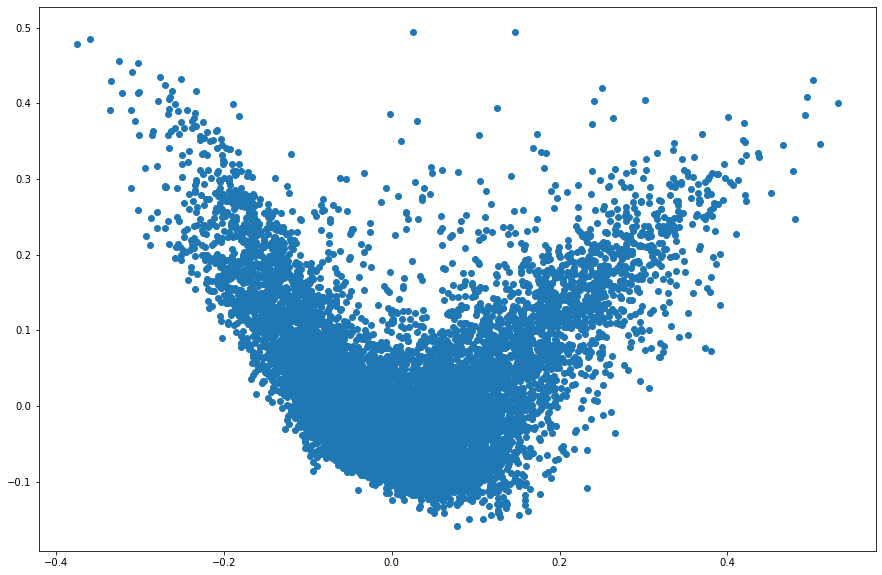

In [17]:
#use predict labels by kmeans for example
plt.figure(figsize=(15,10))
plt.scatter(X_pca[:,0], X_pca[:,1]);

### B.2.b. TSNE

In [18]:
tsne = manifold.TSNE(n_components=2, perplexity=20, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_tfidf)
print(X_tsne.shape)

(20001, 2)


Text(0.5, 1.0, 'Perplexity=20')

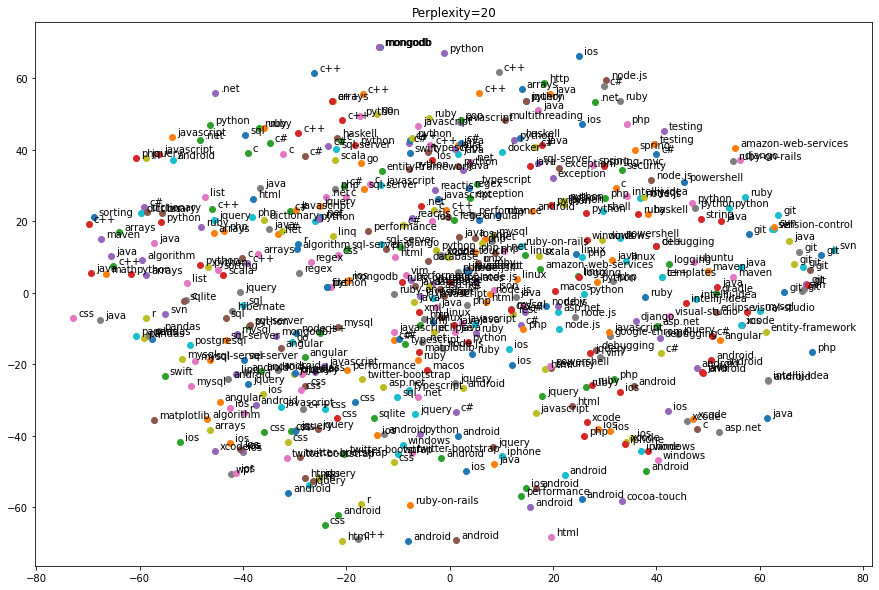

In [20]:
#for p in [10, 20, 30, 40, 50]:
n_plot_words = 500
fig = plt.figure(figsize=(15, 10))
for i in range(n_plot_words):
    plt.scatter(X_tsne[i,0], X_tsne[i,1])
    plt.annotate(train.loc[i, 'First_tag'], xy=(X_tsne[i, 0], X_tsne[i, 1]), xytext=(5,2), textcoords='offset points')
plt.title("Perplexity={}".format(20))

# C. Plongement (Word2Vec)

In [26]:
w2v = word2vec.Word2Vec(list(train['Clean_Tokens']), size=300, window=10, min_count=2, workers=multiprocessing.cpu_count())

## C.1. Par groupe de mots 

In [32]:
tags = [j for i in train['Labels'] for j in i.split(", ") if j != '' and j in w2v.wv.vocab]
total_tags = len(list(set(tags)))
print(total_tags)

82


In [33]:
embedding_clusters = []
word_clusters = []
max_tags = 10
n_top_word = 30
for word in tags[:max_tags]:
    embeddings = []
    words = []
    for similar_word, _ in w2v.wv.most_similar(word, topn=n_top_word):
        words.append(similar_word)
        embeddings.append(w2v.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [34]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne = manifold.TSNE(n_components=2, perplexity=20, init='pca', random_state=0)
X_w2v = np.array(tsne.fit_transform(embedding_clusters.reshape(n*m, k))).reshape(n,m,2)
X_w2v.shape

(10, 30, 2)

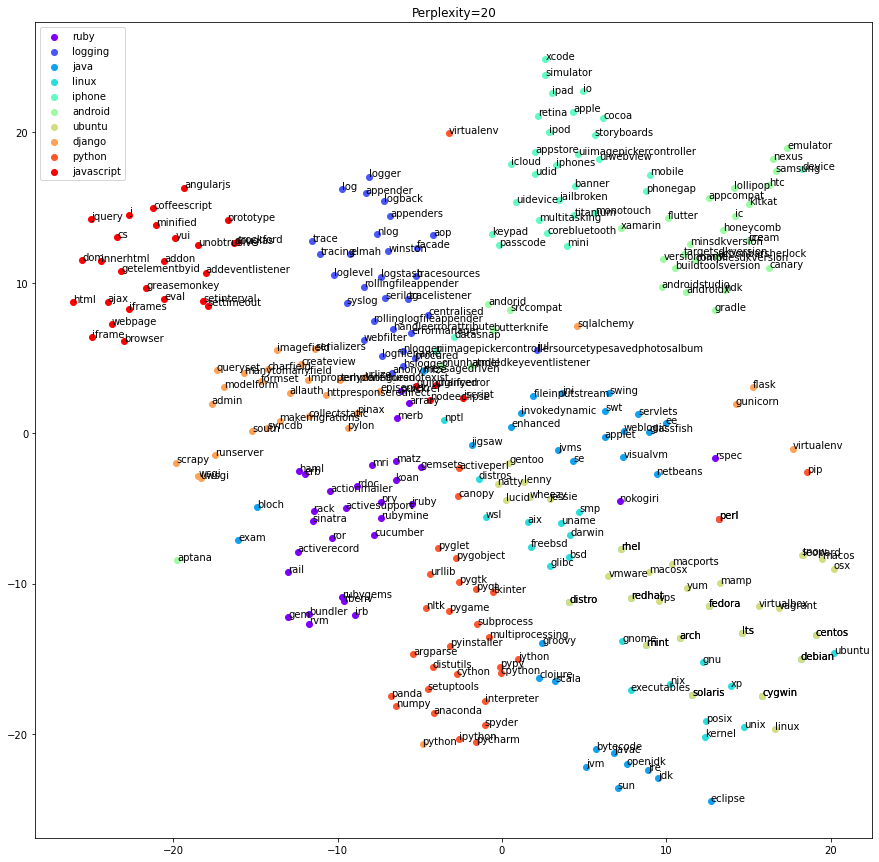

In [35]:
#for p in [10, 20, 30, 40, 50]:
#plot
plt.figure(figsize=(15, 15))
colors = cm.rainbow(np.linspace(0,1,max_tags))
for label, embeddings, words, color in zip(tags, X_w2v, word_clusters, colors):
    x=embeddings[:, 0]
    y=embeddings[:, 1]
    plt.scatter(x, y, color=color, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(x[i], y[i]), xytext=(0,0), textcoords='offset points')
plt.title("Perplexity={}".format(20))
plt.legend();

## C.2. Sur tous les mots

In [36]:
tokens =[]
labels =[]
for word in w2v.wv.vocab:
    tokens.append(w2v.wv[word])
    labels.append(word)

In [37]:
tsne_all = manifold.TSNE(perplexity=30, n_components=2, init='pca',random_state=0)
X_all = tsne_all.fit_transform(tokens[:n_words])

In [38]:
print(len(labels))
print(X_all.shape)

49783
(49783, 2)


Text(0.5, 1.0, 'Perplexity=30')

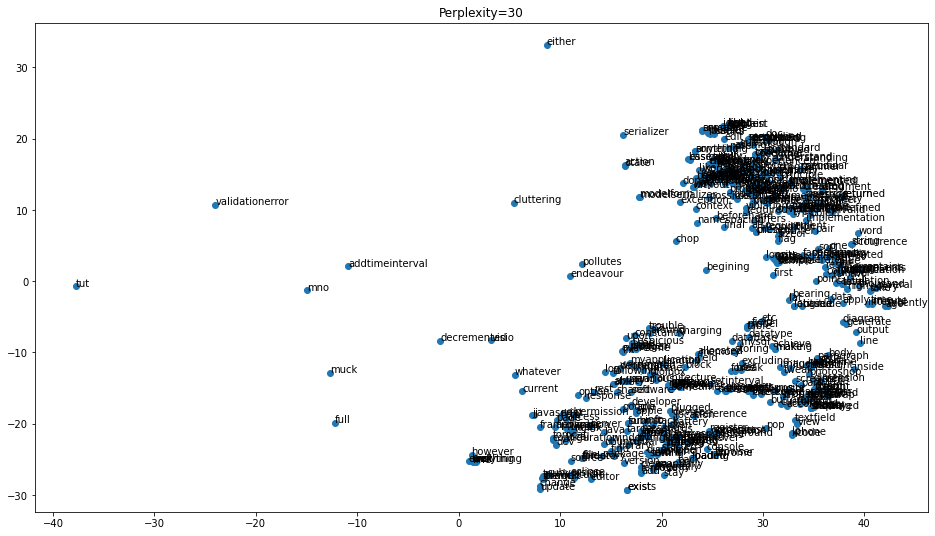

In [40]:
plt.figure(figsize=(16, 9))
n_plot_words = 500
x = X_all[:n_plot_words,0]
y = X_all[:n_plot_words,1]
plt.scatter(x, y)
for i, word in enumerate(labels[:n_plot_words]):
    plt.annotate(word, xy=(x[i], y[i]), xytext=(0,0), textcoords='offset points')
plt.title("Perplexity={}".format(30))

# D. Modélisations

## D.1. Modèles supervisés

### D.1.a. Random Forest

In [41]:
#prio
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_cv, train.loc[:n_posts, 'First_tag'])

RandomForestClassifier()

In [ ]:
#result = rf.predict_proba(testDatafromTfidf)

### D.1.b. Régréssion logistique

### D.1.c LinearSVC

### D.1.d. Gradient boosting

### D.1.e. KNN

In [ ]:
#oneVersusRestClassifier

In [ ]:
#Multinomial naive bayes classifier
#SGDClassifier
#TFIDF sur CountVectorizer?
#https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## D.2. Modèles non supervisés

In [42]:
def display_topics(model, feature_names, n_top_words):
    for i, topic in enumerate(model.components_):
        print("Topics {}".format(i))
        print(" ".join([feature_names[j] for j in topic.argsort()[:-n_top_words - 1 : -1]]))

In [ ]:
# Evaluation score avec Jaccard

### D.2.a. LDA

In [43]:
# Réduction dimensionnelle incluse
lda = LatentDirichletAllocation(n_components=total_tags,
                               #max_iter=5, 
                               learning_method='online', 
                               learning_offset=50., 
                               random_state=0)

lda.fit(X_cv)

#Affichage des thèmes
display_topics(lda, counter_feature_names, n_top_word)

Topics 0
loop index compiler dictionary call vector new code use gcc object rule move assignment performance using order one reference boost iteration without macro timeout assigned better clang derived reason compiled
Topics 1
variable option exists condition undefined scope global var exist limit specified next upon light already behaviour throwing importing may skip wish conditional defined lack frequently named using shed accessible avoid
Topics 2
browser google chrome firefox ie issue localstorage jwt latest anything code based return trying desktop value need process mac jasmine included settimeout xmlhttprequest upload presented webapi switching patch consider prevent
Topics 3
show log reference console configuration assembly see ubuntu tomcat wrapper built company heroku could vm firebug com followed look information helping deployed thats may guessing nothing need problem idea running
Topics 4
function call parameter argument return pas called syntax calling hash passed foo ca

In [44]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
first_topic_words = [counter_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [counter_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]

In [ ]:
#word cloud

### D.2.b. NMF

In [45]:
nmf = NMF(n_components=total_tags,
         random_state=0,
         alpha=1., 
         l1_ratio=0.5, 
         init='nndsvd')
nmf.fit(X_tfidf)

#Affichage des thèmes
display_topics(nmf, tfidf_feature_names, n_top_word)

Topics 0
zoom finding firstly firing firefox fired firebug firebase finished finish fine finally field final filtering filter filled filesystem filename file figuring figured fit fix fixed fixing follows following followed follow
Topics 1
zoom finding firstly firing firefox fired firebug firebase finished finish fine finally field final filtering filter filled filesystem filename file figuring figured fit fix fixed fixing follows following followed follow
Topics 2
file directory folder using error line want project way like use code command read python path need script work text run create open following trying add problem tried class upload
Topics 3
zoom finding firstly firing firefox fired firebug firebase finished finish fine finally field final filtering filter filled filesystem filename file figuring figured fit fix fixed fixing follows following followed follow
Topics 4
string convert character like want way value using python java function method object list code return example 

### D.2.f. KMeans

In [46]:
# recherche du meilleur nombre de clusters
kmeans = KMeans(n_clusters = n_clust)
centroids = kmeans.fit_predict(train['Tokens'])

# Recherche du mot le plus proche du centroide de chaque cluster (parmi notre liste de tags ou de mots)

# Affichages par label

NameError: name 'n_clust' is not defined

In [ ]:
#Predictions des labels sur jeu de test
#Exercice 3
# http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_sentiment_analysis_correction2html.html